In [1]:
 # --- 配置路径 (请根据你的实际文件名修改) ---
BAM_FILE = "/data/work/human_brain/710_68_1_humanbrain_251209_NB.duplicates.directional.bam"  # 68_1 UMI去重bam
GTF_FILE = "/data/work/human_brain/genes.gtf"
FASTA_FILE = "/data/work/human_brain/genome.fasta"
DB_FILE = "/data/work/hg38_annotations.db" # 运行后生成的数据库缓存

In [2]:
import gffutils
import os

def load_or_create_gtf_db(gtf_path, db_path, force_rebuild=False):
    """
    加载已有的 GTF 数据库，如果不存在则创建一个。
    
    参数:
    - gtf_path: 原始 GTF 文件路径
    - db_path: 生成的 SQLite 数据库存储路径
    - force_rebuild: 是否强制删除旧数据库重新构建 (默认 False)
    """
    
    # 1. 检查是否需要重新构建
    if force_rebuild and os.path.exists(db_path):
        print(f"提示：正在删除旧数据库以重新构建: {db_path}")
        os.remove(db_path)

    # 2. 如果数据库已存在，直接加载
    if os.path.exists(db_path):
        print(f"--- 正在加载现有数据库: {db_path} ---")
        # 直接连接现有的数据库文件
        db = gffutils.FeatureDB(db_path)
    else:
        # 3. 如果数据库不存在，启动构建流程
        print(f"--- 首次运行：正在解析 GTF 并创建数据库 ---")
        print(f"源文件: {gtf_path}")
        print("提示：此过程通常需要 5-20 分钟，请耐心等待...")
        
        try:
            db = gffutils.create_db(
                gtf_path, 
                db_path, 
                force=True, 
                keep_order=True,
                # 基因组级别分析建议禁用推测，以加快速度
                disable_infer_genes=True, 
                disable_infer_transcripts=True,
                verbose=True  # 实时显示处理行数
            )
            print("--- 数据库构建成功并已加载！ ---")
        except Exception as e:
            print(f"错误：构建数据库失败。原因: {e}")
            if os.path.exists(db_path):
                os.remove(db_path) # 清理半成品
            return None
            
    return db

# --- 使用方法示例 ---
# GTF_FILE = "genes.gtf"
# DB_FILE = "hg38_annotations.db"

# 1. 正常加载
# db = load_or_create_gtf_db(GTF_FILE, DB_FILE)

# 2. 如果你更换了参考基因组或发现之前的数据库有问题，可以强制刷新：
# db = load_or_create_gtf_db(GTF_FILE, DB_FILE, force_rebuild=True)

In [3]:
db = load_or_create_gtf_db(GTF_FILE, DB_FILE)

--- 正在加载现有数据库: /data/work/hg38_annotations.db ---


In [4]:
import pysam
import pandas as pd
from intervaltree import IntervalTree

def analyze_capture_full_details(bam_path, db):
    # --- 步骤 1: 构建内存基因结构索引 ---
    print("--- 步骤 1: 构建内存基因结构索引 (Exons/Introns) ---")
    gene_index = {}
    gene_structures = {} 

    for gene in db.features_of_type('gene'):
        chrom = gene.chrom
        strand = gene.strand
        g_id = gene.id
        g_name = gene.attributes.get('gene_name', [g_id])[0]
        
        if chrom not in gene_index:
            gene_index[chrom] = IntervalTree()
        
        gene_index[chrom].addi(gene.start, gene.end, g_id)
        
        last_exons = set()
        all_exons = set() 
        
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            
            target_last = exons[-1] if strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'name': g_name,
            'strand': strand,
            'last_exons': last_exons,
            'all_exons': all_exons,
            'g_range': (gene.start, gene.end)
        }

    # --- 步骤 2: 扫描 BAM 文件并记录精确坐标 ---
    print("--- 步骤 2: 开始扫描 BAM 并提取坐标 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = [] 
    
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}
    total_primary = 0

    for read in bf.fetch(until_eof=True):
        # 过滤非主要比对
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
            
        total_primary += 1
        chrom = read.reference_name
        r_start = read.reference_start
        r_end = read.reference_end  # <--- 获取精确的参考基因组终止坐标
        
        # 检索该 Read 所在的基因区间
        matches = gene_index.get(chrom, IntervalTree()).overlap(r_start, r_end)
        if not matches:
            counts["Other"] += 1
            continue
            
        g_id = list(matches)[0].data
        struct = gene_structures[g_id]
        strand = struct['strand']
        g_s, g_e = struct['g_range']
        
        # 1. 根据链的方向定义捕获位点 (Capture Site)
        capture_site = r_end if strand == '+' else r_start
        
        # 2. 计算相对位置
        if (g_e - g_s) != 0:
            rel_pos = (capture_site - g_s) / (g_e - g_s) if strand == '+' else (g_e - capture_site) / (g_e - g_s)
        else:
            rel_pos = 0
        rel_pos = max(0, min(1, rel_pos))

        # 3. 三级判定逻辑 (判定捕获点落在什么位置)
        location = "Intron" 
        is_matched = False
        
        for s, e in struct['last_exons']:
            if s <= capture_site <= e:
                location = "Last Exon"
                counts["Last Exon"] += 1
                is_matched = True
                break
        
        if not is_matched:
            for s, e in struct['all_exons']:
                if s <= capture_site <= e:
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    is_matched = True
                    break
        
        if not is_matched:
            counts["Intron"] += 1
        
        # --- 结果记录：包含 read_end 供后续几何分析使用 ---
        results_list.append({
            'read_name': read.query_name,      # 用于唯一标识
            'chrom': chrom,                   # 用于定位
            'read_start': r_start,            # 用于定位
            'read_end': r_end,                # <--- 新增：全长 Read 的终止坐标
            'gene_id': g_id,                  # 用于关联基因结构
            'rel_pos': rel_pos,               # 相对位置百分比
            'location': location              # 所在区域分类
        })

        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")

    bf.close()

    # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
    
    return pd.DataFrame(results_list)

In [5]:
df_results = analyze_capture_full_details(BAM_FILE, db) 

--- 步骤 1: 构建内存基因结构索引 (Exons/Introns) ---
--- 步骤 2: 开始扫描 BAM 并提取坐标 ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 6500000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    1746481 (22.79%)
Internal Exon  :     349986 (4.57%)
Intron         :    5565677 (72.64%)
Other/Intergenic:          0


In [7]:
def analyze_capture_by_tag(bam_path, db):
    # --- 步骤 1: 建立 ID 映射字典 (极速) ---
    print("--- 步骤 1: 构建基因结构字典 ---")
    gene_structures = {}
    for gene in db.features_of_type('gene'):
        g_id = gene.id  # 确保这里的 ID 能匹配上 ENSG00000241599 这种格式
        
        # 提取该基因所有的末端外显子和全部外显子
        last_exons = set()
        all_exons = set()
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            target_last = exons[-1] if gene.strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'strand': gene.strand,
            'last_exons': last_exons,
            'all_exons': all_exons,
            'g_range': (gene.start, gene.end)
        }

    # --- 步骤 2: 遍历 BAM，直接通过 GX 标签获取结构 ---
    print("--- 步骤 2: 开始扫描 BAM 并提取坐标 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = []
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}

    
    total_primary = 0
    
    for read in bf.fetch(until_eof=True):
        total_primary += 1
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        
        
        # 直接获取 Gene ID <--- 新增: 用bam文件中的基因注释
        try:
            gx_id = read.get_tag('GX')
        except KeyError:
            counts["Other"] += 1
            continue
        
        # 如果数据库里没有这个基因，跳过
        if gx_id not in gene_structures:
            counts["Other"] += 1
            continue
            
        struct = gene_structures[gx_id]
        
        # 1. 根据链的方向定义捕获位点 (Capture Site)
        r_start = read.reference_start
        r_end = read.reference_end
        strand = struct['strand'] # 从数据库获取该基因的正负链
        capture_site = r_end if strand == '+' else r_start
    

        # 2. 三级判定逻辑 (判定捕获点落在什么位置)
        location = "Intron" 
        is_matched = False
        
        for s, e in struct['last_exons']:
            if s <= capture_site <= e:
                location = "Last Exon"
                counts["Last Exon"] += 1
                is_matched = True
                break
        
        if not is_matched:
            for s, e in struct['all_exons']:
                if s <= capture_site <= e:
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    is_matched = True
                    break
        
        if not is_matched:
            counts["Intron"] += 1

    # 记录详细信息供后续分析
        results_list.append({
            'read_name': read.query_name,
            'gene_id': gx_id,
            'read_start': r_start,            # 用于定位
            'read_end': r_end,                # <--- 新增：全长 Read 的终止坐标
            'location': location              # 所在区域分类
        })

        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")

    bf.close()
   # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
   
    return pd.DataFrame(results_list)

In [8]:
df_results_v2 = analyze_capture_by_tag(BAM_FILE, db)

--- 步骤 1: 构建基因结构字典 ---
--- 步骤 2: 开始扫描 BAM 并提取坐标 ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    1910302 (26.17%)
Internal Exon  :     349480 (4.79%)
Intron         :    5039270 (69.04%)
Other/Intergenic:     363092


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_capture_relative_distribution(df):
    """
    df 必须包含: 
    - rel_pos: 基于最长基因范围计算的 0-1 位置
    - location: 上一步统计出的 'Last Exon', 'Internal Exon', 'Intron'
    """
    
    print("--- 正在生成捕获位点相对位置分布图 ---")
    
    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    
    # 1. 准备数据
    # 正常捕获：Last Exon
    normal_reads = df[df['location'] == "Last Exon"]['rel_pos']
    # Internal Priming：Intron
    ip_reads = df[df['location'] == "Intron"]['rel_pos']
    
    # 2. 绘制密度曲线 (KDE)
    # 绿色代表正常捕获
    sns.kdeplot(normal_reads, bw_adjust=0.5, label=f"Normal Capture (n={len(normal_reads)})", 
                color="green", fill=True, alpha=0.3)
    
    # 红色代表内含子内部捕获
    sns.kdeplot(ip_reads, bw_adjust=0.5, label=f"Internal Priming (n={len(ip_reads)})", 
                color="red", fill=True, alpha=0.3)
    
    # 3. 修饰图表
    plt.title("Relative Position of Capture Sites on Gene Body (Longest Ref)", fontsize=15)
    plt.xlabel("Relative Position (0 = 5' End, 1 = 3' End)", fontsize=12)
    plt.ylabel("Density of Capture Events", fontsize=12)
    plt.xlim(-0.05, 1.05)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.legend(loc="upper left")
    
    # 添加一个注释说明
    plt.text(0.1, plt.gca().get_ylim()[1]*0.8, 
             "Red: Intronic Capture\nGreen: Last Exon Capture", 
             bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

# --- 补充逻辑：如何计算基于最长转录本的 rel_pos ---
# 在你明天的脚本循环中，可以加入以下逻辑：
# 1. 找到该基因所有转录本中 start 最小、end 最大的范围作为 "Full Gene Length"
# 2. rel_pos = abs(capture_site - 5_prime_end) / full_gene_length

--- 正在生成捕获位点相对位置分布图 ---


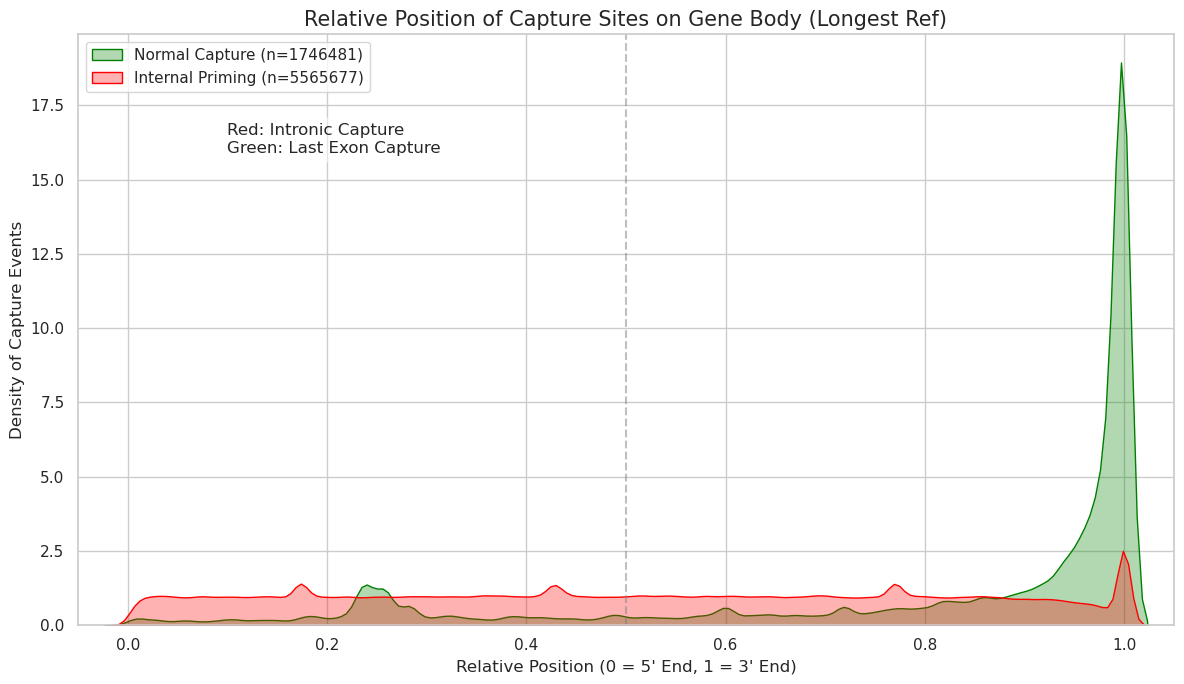

In [15]:
plot_capture_relative_distribution(df_results)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_and_extract_target_ip(df, near_3p_threshold=0.99, target_threshold=0.99):
    """
    1. 绘制 IP 分布图
    2. 筛选并返回 RelPos < 0.99 的目标 Reads DataFrame，用于后续 CIGAR 解析
    """
    # --- 1. 数据筛选 ---
    # 仅保留内含子捕获
    ip_df = df[df['location'] == "Intron"].copy()
    
    # 提取你的目标子集 (RelPos < 0.99)
    # 这个 target_df 就是你要拿去跑 CIGAR 解析的 23 万条数据
    target_df = ip_df[ip_df['rel_pos'] > target_threshold].copy()
    
    total_ip = len(ip_df)
    target_count = len(target_df)
    
    if total_ip == 0:
        print("错误: 未发现任何 Intron 捕获记录。")
        return None

    # --- 2. 统计打印 (修正了变量名引用) ---
    near_3p_df = ip_df[ip_df['rel_pos'] >= near_3p_threshold]
    near_3p_count = len(near_3p_df)
    # 修正：原代码中 total_ip_count 未定义，应为 total_ip
    near_3p_ratio = (near_3p_count / total_ip) * 100

    print(f"--- 统计结果 ---")
    print(f"Internal Priming (Intron) 总数: {total_ip}")
    print(f"靠近 3' 端 (RelPos >= {near_3p_threshold}) 的数量: {near_3p_count}")
    print(f"在 IP 中的占比: {near_3p_ratio:.2f}%")
    print(f"已提取目标子集 (RelPos > {target_threshold}) 数量: {target_count}")

    # --- 3. 绘图部分 ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # 绘制整体 IP 分布 (Counts)
    ax = sns.histplot(ip_df['rel_pos'], bins=100, kde=True, color="red", alpha=0.4, edgecolor=None)

    # 修饰图表
    plt.title(f"Genomic Distribution of Internal Priming (n={total_ip})", fontsize=14)
    plt.xlabel("Relative Position (0 = 5' End, 1 = 3' End)", fontsize=12)
    plt.ylabel("Read Counts", fontsize=12)
    plt.xlim(0, 1.05) # 稍微放宽一点边界，能看到 1.0 处的柱子

    # 绘制阈值线
    plt.axvline(x=near_3p_threshold, color='darkred', linestyle='--')
    
    # 标注文本 (修正了坐标偏移和文本内容)
    plt.text(near_3p_threshold - 0.15, ax.get_ylim()[1] * 0.7, 
             f"Near 3' Zone\n({near_3p_ratio:.2f}%)", 
             color='darkred', weight='bold', bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # --- 4. 返回目标子集 ---
    # 这里的 target_df 携带了所有的原始信息（read_id, chrom, start, end 等）
    return target_df

--- 统计结果 ---
Internal Priming (Intron) 总数: 5565677
靠近 3' 端 (RelPos >= 0.99) 的数量: 232170
在 IP 中的占比: 4.17%
已提取目标子集 (RelPos > 0.99) 数量: 232170


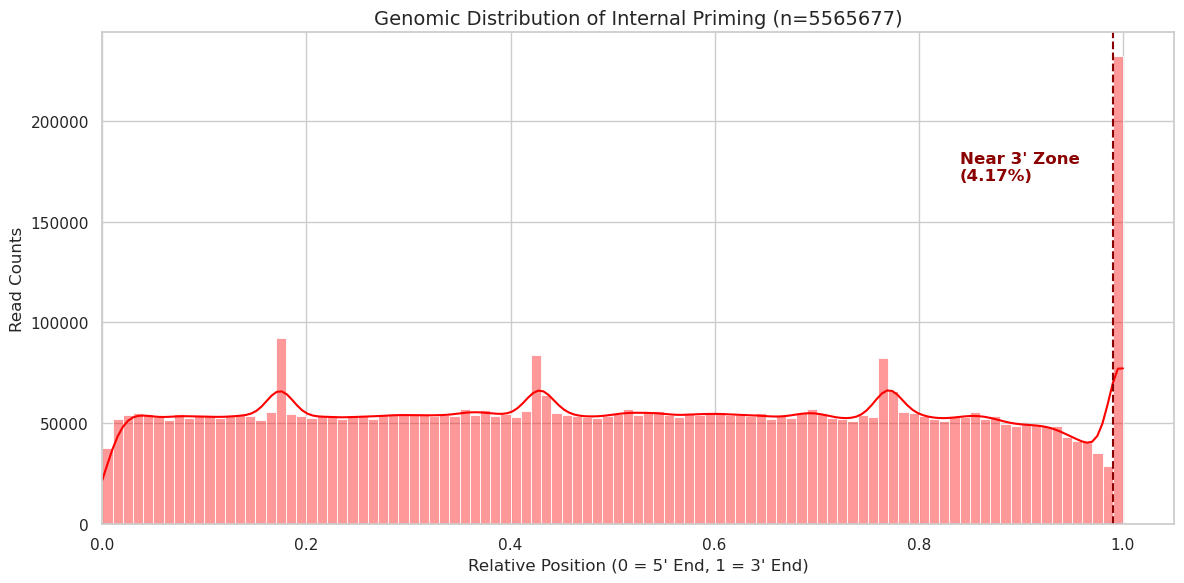

In [7]:
df_target_23w = plot_and_extract_target_ip(df_results)

In [14]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from intervaltree import IntervalTree

def analyze_target_n_and_overlap(bam_path, db, target_df):
    """
    针对 RelPos > 0.99 的目标 Reads (使用 read_name 列):
    1. 统计含有 N (剪接信号) 的比例
    2. 计算在当前内含子内的连续比对长度
    """
    # 1. 获取目标 ID 集合
    if 'read_name' not in target_df.columns:
        print("错误: 提供的 DataFrame 中找不到 'read_name' 列。")
        return None
        
    target_qnames = set(target_df['read_name'])
    print(f"--- 成功加载 {len(target_qnames)} 条目标 Reads ---")

    # 2. 【核心修复步】构建内含子索引
    # 确保 intron_index 在此处被正确初始化
    print("--- 步骤 1: 构建基因组内含子索引 ---")
    intron_index = {}
    
    # 遍历数据库构建区间树
    for gene in db.features_of_type('gene'):
        chrom, strand = gene.chrom, gene.strand
        # 获取该基因所有外显子
        exons = sorted(list(db.children(gene, featuretype='exon')), key=lambda e: e.start)
        if len(exons) < 2: 
            continue
            
        if chrom not in intron_index:
            intron_index[chrom] = IntervalTree()
            
        # 计算外显子之间的间隙作为内含子
        for i in range(len(exons) - 1):
            i_start, i_end = exons[i].end + 1, exons[i+1].start - 1
            if i_end > i_start:
                # 存储内含子边界和链信息
                intron_index[chrom].addi(i_start, i_end, (i_start, i_end, strand))

    # 3. 扫描 BAM 文件
    bf = pysam.AlignmentFile(bam_path, "rb")
    results = []
    n_count = 0
    total_processed = 0

    print("--- 步骤 2: 正在扫描 BAM 文件提取 CIGAR 信息 ---")
    for read in bf:
        # 过滤非 primary reads
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
            
        # 仅处理目标集合中的 Read
        if read.query_name in target_qnames:
            total_processed += 1
            
            # 统计 N 比例
            has_n = True if (read.cigarstring and 'N' in read.cigarstring) else False
            if has_n: n_count += 1
            
            # 计算连续内含子长度
            chrom = read.reference_name
            # 判定 3' 捕获端
            capture_site = read.reference_end if not read.is_reverse else read.reference_start
            
            # 安全检查索引是否存在该染色体
            if chrom in intron_index:
                matches = intron_index[chrom].at(capture_site)
                if matches:
                    for m in matches:
                        i_start, i_end, _ = m.data
                        # 解析 CIGAR 序列
                        ops = read.cigartuples[::-1] if not read.is_reverse else read.cigartuples
                        
                        contiguous_len = 0
                        for op, length in ops:
                            if op in (0, 2, 7, 8): # M, D, =, X
                                contiguous_len += length
                            elif op == 3: # N (遇到了剪接跳跃)
                                break
                            elif op == 4: # S (忽略 Soft clip)
                                continue
                            
                            # 边界检查
                            curr_pos = capture_site - contiguous_len if not read.is_reverse else capture_site + contiguous_len
                            if not (i_start <= curr_pos <= i_end):
                                contiguous_len -= abs(curr_pos - (i_start if not read.is_reverse else i_end))
                                break
                        
                        results.append({'read_name': read.query_name, 'overlap': max(0, contiguous_len), 'has_n': has_n})
                        break # 一个 read 匹配到一个内含子即可

    bf.close()

    # 4. 输出统计数据
    if total_processed > 0:
        n_ratio = (n_count / total_processed) * 100
        print("\n" + "="*45)
        print(f"目标子集 (RelPos > 0.99) 最终统计报告")
        print("-" * 45)
        print(f"匹配到的目标 Reads 总数 : {total_processed}")
        print(f"含有 N (已剪接)         : {n_count}")
        print(f"不含 N (完全连续)       : {total_processed - n_count}")
        print(f"N 占比 (Spliced Ratio)  : {n_ratio:.2f}%")
        print("="*45)
    else:
        print("警告: 未能在 BAM 中匹配到任何 Read，请核对 ID 格式。")

    return pd.DataFrame(results)

In [11]:
print(df_target_23w.columns)

Index(['read_name', 'chrom', 'read_start', 'read_end', 'gene_id', 'rel_pos',
       'location'],
      dtype='object')


In [15]:
df_final_stats = analyze_target_n_and_overlap(BAM_FILE, db, df_target_23w)

--- 成功加载 232170 条目标 Reads ---
--- 步骤 1: 构建基因组内含子索引 ---
--- 步骤 2: 正在扫描 BAM 文件提取 CIGAR 信息 ---

目标子集 (RelPos > 0.99) 最终统计报告
---------------------------------------------
匹配到的目标 Reads 总数 : 232170
含有 N (已剪接)         : 142995
不含 N (完全连续)       : 89175
N 占比 (Spliced Ratio)  : 61.59%


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_overlap_xlim(df):
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图
    # 23万数据建议 bins 设多一些（如 150），观察细节更准
    sns.histplot(data=df, x='overlap', bins=150, color='teal', kde=True)
    
    # 设置坐标轴标签和标题
    plt.title("Contiguous Alignment Length in Intron (RelPos > 0.99)", fontsize=14)
    plt.xlabel("Contiguous Length in Intron (bp)", fontsize=12)
    plt.ylabel("Counts (Number of Reads)", fontsize=12)
    
    # --- 核心需求：设置横坐标范围 0-3000 ---
    plt.xlim(0, 3000)
    
    # 纵坐标不设限，让它根据数据自动伸缩
    
    # 添加中位数和均值参考线
    median_val = df['overlap'].median()
    mean_val = df['overlap'].mean()
    plt.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.1f} bp')
    plt.axvline(mean_val, color='orange', linestyle=':', label=f'Mean: {mean_val:.1f} bp')
    
    plt.legend()
    plt.grid(axis='y', alpha=0.3, linestyle=':')
    plt.show()

# 执行绘图
# plot_target_overlap_xlim(df_final_stats)

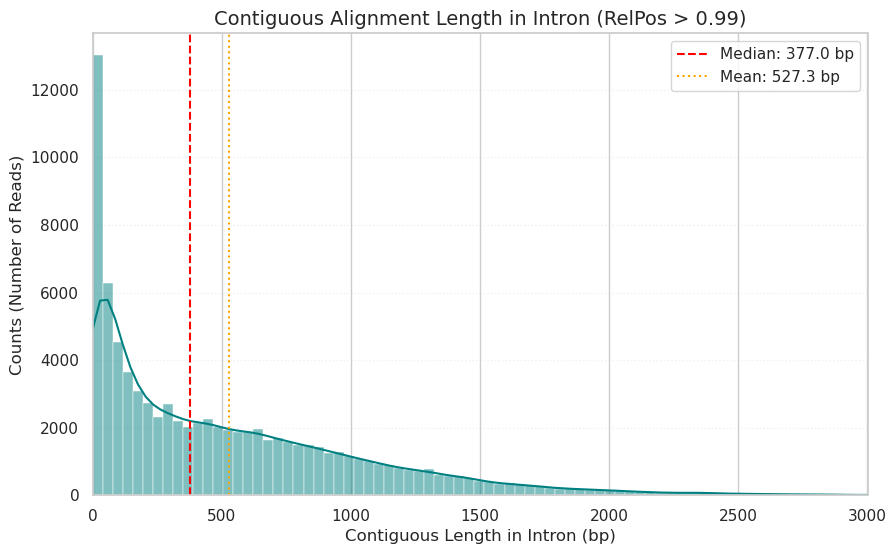

In [24]:
plot_target_overlap_xlim(df_final_stats)

In [18]:
import pysam
import random

def inspect_spliced_intron_cigar(bam_path, target_df, sample_size=40):
    # 筛选含有 N 的目标 Read ID
    # 假设你的 df_final_stats 已经包含了 'has_n' 信息
    spliced_ids = set(target_df[target_df['has_n'] == True]['read_name'])
    
    if not spliced_ids:
        print("未找到含有 N 的目标 Reads。")
        return

    sample_ids = random.sample(list(spliced_ids), min(len(spliced_ids), sample_size))
    
    print(f"--- 抽样查看 {len(sample_ids)} 条含有 N 的内含子 Reads ---")
    print(f"{'Read Name':<20} | {'CIGAR String':<40} | {'Span (bp)'}")
    print("-" * 75)

    bf = pysam.AlignmentFile(bam_path, "rb")
    for read in bf:
        if read.query_name in sample_ids:
            # 计算在基因组上的跨度 (end - start)
            span = read.reference_end - read.reference_start
            print(f"{read.query_name:<20} | {read.cigarstring:<40} | {span:<10}")
            # 简单解析一下 CIGAR 中的 N 长度
            n_lengths = [length for op, length in read.cigartuples if op == 3]
            if n_lengths:
                print(f"  └─ 包含 {len(n_lengths)} 个剪接点，跳跃长度分别为: {n_lengths}")
            
            sample_ids.remove(read.query_name)
            if not sample_ids:
                break
    bf.close()

# 调用抽样查看
# inspect_spliced_intron_cigar(BAM_FILE, df_final_stats)

In [19]:
inspect_spliced_intron_cigar(BAM_FILE, df_final_stats)

--- 抽样查看 40 条含有 N 的内含子 Reads ---
Read Name            | CIGAR String                             | Span (bp)
---------------------------------------------------------------------------
250F701086011_29_7179_24279_513559145_37709_3_11.68 | 2S32M2I12M1D1M1D75M1D45M3D85M2I4M3D29M1D76M1I91M2D55M1I11M2D3M1I55M2D25M1D75M1I26M1D39M196N17M1D36M4D41M2I55M2D61M2D6M2I24M1D1M1D3M1D5M2I25M2D31M210N103M138N79M1D19M1I15M1I1M1I4M2D7M2I4M2I65M7D57M1D73M1D54M1I34M3D33M1D80M1I78M1D35M1I23M4D18M1I5M1D48M1D24M1D39M2D107M1D19M1I18M1D17M5D2M1D6M6D3M1I35M1I86M1D42M2I57M1D9M1I3M1I2M1I3M1D76M1D24M1I4M2D21M1I7M1I77M1D13M1I18M3D9M1D9M6D19M2D35M2D14M2D21M1I18M1D14M1D15M47S | 3386      
  └─ 包含 3 个剪接点，跳跃长度分别为: [196, 210, 138]
250F701086011_10_5844_8450_167771983_22410_3_12.25 | 5S13M1D8M3I17M2D5M2D1M1D28M1D26M4D64M1D51M1D22M2I13M1D26M2D2M5I1M16872N1I10M1D121M1D8M1D24M1I6M4D98M1D50M84860N41M1I36M3D43M2D1M2023N19M1I8M2D7M1D14M1I12M1D47M1D1M1D10M1D54M1D13M1154N90M2820N41M2D3M2I55M1I1M2D89M1I51M2I72M1D1M1D4M2I56M1D48M1

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_overlap_with_stats_clear(df):
    plt.figure(figsize=(12, 7))
    
    # 1. 设置更清晰的配色
    color_map = {True: "#27AE60", False: "#F39C12"}  # 绿色 vs 橙色
    
    # 2. 计算合适的bin宽度
    # 根据数据范围和想要的清晰度调整
    bin_width = 20  # 每个bin 20bp，可以根据需要调整
    bins = int(3000 / bin_width)  # 0-3000范围，150个bins
    
    # 3. 绘制更清晰的直方图
    ax = sns.histplot(
        data=df, 
        x='overlap', 
        hue='has_n', 
        bins=bins,
        palette=color_map,
        alpha=0.7,          # 稍微增加透明度
        edgecolor='white',  # 添加白色边框
        linewidth=0.5,      # 边框线宽
        kde=False,          # 先不显示KDE，让柱状图更清晰
        stat='count',       # 显示计数
        common_norm=False   # 每组独立
    )
    
    # 4. 设置坐标轴和标题
    plt.xlim(0, 3000)
    plt.title("Contiguous Alignment Length within the Current Intron", 
              fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Contiguous Length in Intron (bp)", fontsize=13)
    plt.ylabel("Counts (Number of Reads)", fontsize=13)
    
    # 5. 计算统计值
    spliced_data = df[df['has_n'] == True]['overlap']
    unspliced_data = df[df['has_n'] == False]['overlap']
    
    stats = {
        'spliced': {
            'median': spliced_data.median(),
            'mean': spliced_data.mean(),
            'count': len(spliced_data)
        },
        'unspliced': {
            'median': unspliced_data.median(),
            'mean': unspliced_data.mean(),
            'count': len(unspliced_data)
        }
    }
    
    # 6. 添加清晰的统计线
    # Spliced组 - 深绿色
    plt.axvline(stats['spliced']['median'], 
                color='darkgreen', 
                linestyle='--', 
                linewidth=2.5,
                label=f'Spliced Median: {stats["spliced"]["median"]:.0f} bp')
    
    # Unspliced组 - 深橙色
    plt.axvline(stats['unspliced']['median'], 
                color='darkorange', 
                linestyle='--', 
                linewidth=2.5,
                label=f'Unspliced Median: {stats["unspliced"]["median"]:.0f} bp')

    
    # 8. 添加统计信息文本框
    stats_text = (
        f"Spliced Reads: {stats['spliced']['count']:,}\n"
        f"  Median: {stats['spliced']['median']:.0f} bp\n"
        f"  Mean: {stats['spliced']['mean']:.0f} bp\n\n"
        f"Unspliced Reads: {stats['unspliced']['count']:,}\n"
        f"  Median: {stats['unspliced']['median']:.0f} bp\n"
        f"  Mean: {stats['unspliced']['mean']:.0f} bp"
    )
    
    plt.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8),
        fontsize=10,
        fontfamily='monospace'
    )
    
    # 9. 优化图例
    from matplotlib.patches import Patch
    
    # 创建自定义图例元素
    legend_elements = [
        Patch(facecolor='#27AE60', alpha=0.7, label='spliced reads'),
        Patch(facecolor='#F39C12', alpha=0.7, label='consecutive reads'),
    ]
    
    plt.legend(
        handles=legend_elements,
        title="Read Groups",
        loc='upper left',
        fontsize=10,
        title_fontsize=11
    )
    
    # 10. 网格和样式
    plt.grid(axis='y', alpha=0.3, linestyle=':')
    plt.grid(axis='x', alpha=0.2, linestyle=':')
    
    plt.tight_layout()
    plt.show()
    
    return stats

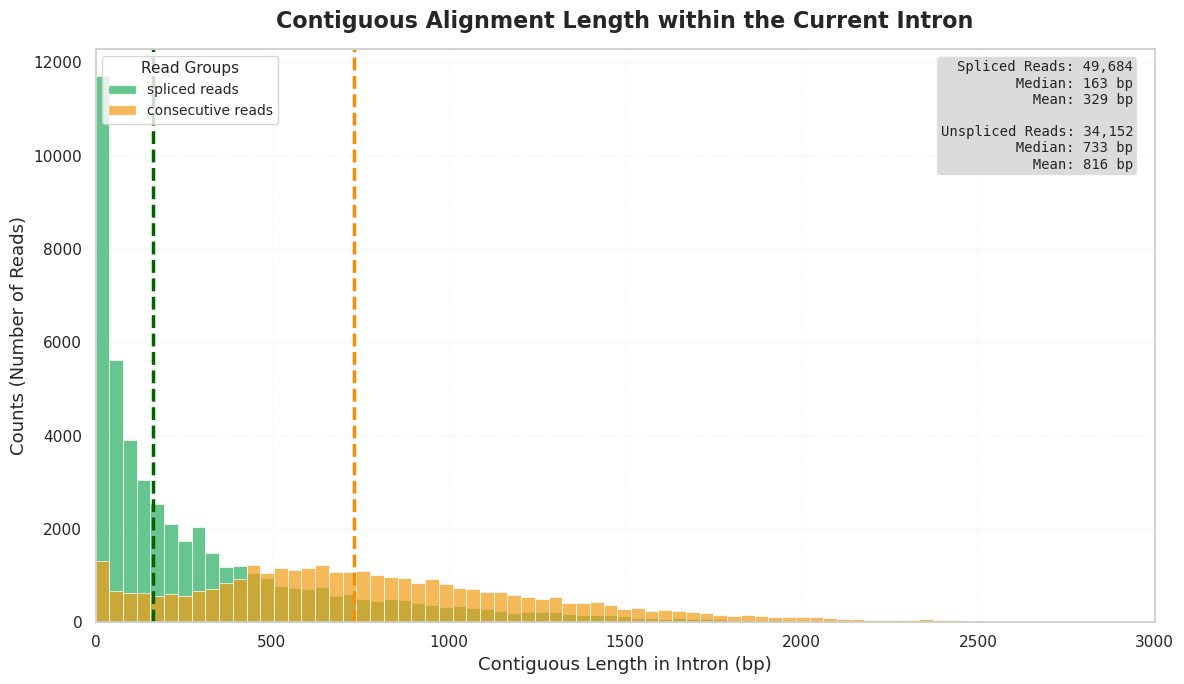

{'spliced': {'median': 163.0,
  'mean': np.float64(328.86291361404074),
  'count': 49684},
 'unspliced': {'median': 733.0,
  'mean': np.float64(815.9187748887327),
  'count': 34152}}

In [69]:
plot_target_overlap_with_stats_clear(df_final_stats)

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_overlap_with_stats(df):
    plt.figure(figsize=(10, 6)) # 稍微增加高度以容纳更多图例
    
    # 1. 绘制直方图
    # palette 设置：True (Spliced) 用红系，False (Unspliced) 用蓝系
    color_map = {True: "green", False: "orange"}
    
    ax = sns.histplot(data=df, x='overlap', hue='has_n', bins=150, 
                      palette=color_map, 
                      element="step", alpha=0.5, kde=True)
    
    # 2. 设置坐标轴和标题
    plt.xlim(0, 3000)
    plt.title("Contiguous Alignment Length within the Current Intron", fontsize=14)
    plt.xlabel("Contiguous Length in Intron (bp)", fontsize=12)
    plt.ylabel("Counts (Number of Reads)", fontsize=12)
    
    # 3. 计算统计值
    # Spliced (Has N)
    spliced_data = df[df['has_n'] == True]['overlap']
    med_s = spliced_data.median()
    mean_s = spliced_data.mean()
    
    # Unspliced (No N)
    unspliced_data = df[df['has_n'] == False]['overlap']
    med_u = unspliced_data.median()
    mean_u = unspliced_data.mean()
    
    # 4. 绘制参考线
    # Spliced 组 
    plt.axvline(med_s, color='darkgreen', linestyle='--', label=f'Spliced Median: {med_s:.1f}')
    
    # Unspliced 组 
    plt.axvline(med_u, color='orange', linestyle='--', label=f'Unspliced Median: {med_u:.1f}')
    
    # 5. 优化图例
    # 注意：由于手动添加了多条线，我们需要合并图例
    plt.legend(title="Statistics & Groups", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='y', alpha=0.3, linestyle=':')
    plt.tight_layout() # 防止图例被遮挡
    plt.show()

# 执行绘图
# plot_target_overlap_with_stats(df_final_stats)

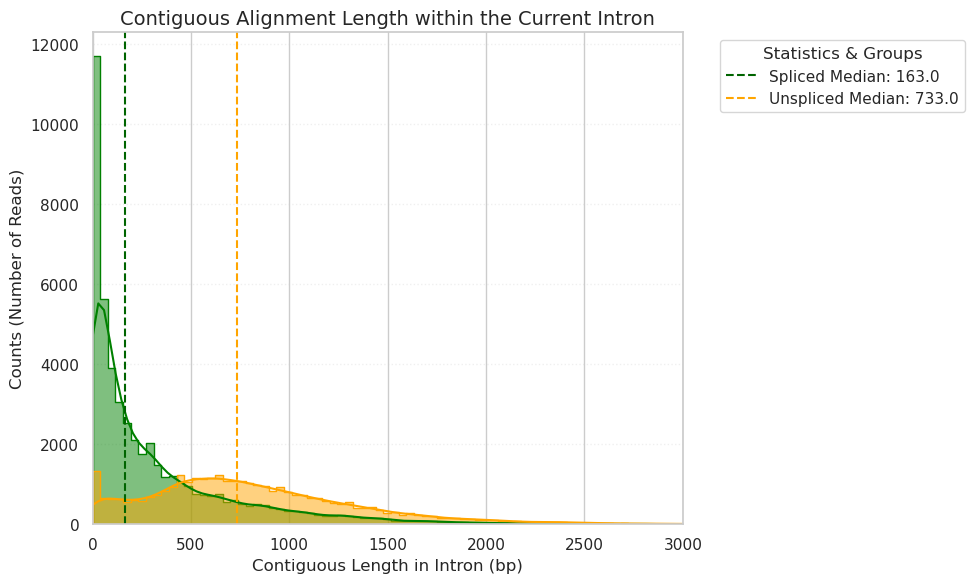

In [63]:
 plot_target_overlap_with_stats(df_final_stats)

## 用Dmin计算非正常捕获

In [4]:
import pysam
import pandas as pd
from intervaltree import IntervalTree

def fast_capture_analysis_no_prior(bam_path, db):
    # --- 第一步：构建内存区间树 (保持不变) ---
    print("--- 步骤 1: 正在构建内存基因索引 (Interval Tree) ---")
    gene_index = {}
    for gene in db.features_of_type('gene'):
        chrom = gene.chrom
        if chrom not in gene_index:
            gene_index[chrom] = IntervalTree()
        gene_index[chrom].addi(gene.start, gene.end, {
            'name': gene.attributes.get('gene_name', [gene.id])[0],
            'strand': gene.strand,
            'id': gene.id
        })
    print("索引构建完成，开始扫描 BAM 文件...")

    # --- 第二步：流式处理 BAM (已整合 D_max 和 rel_pos) ---
    bf = pysam.AlignmentFile(bam_path, "rb")
    results = []
    total_primary_reads = 0
    gene_cache = {}

    # 使用 until_eof=True 确保流式读取
    for i, read in enumerate(bf.fetch(until_eof=True)):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
            
        total_primary_reads += 1
        chrom = read.reference_name
        r_start, r_end = read.reference_start, read.reference_end
        
        if chrom not in gene_index: continue
        matches = gene_index[chrom].overlap(r_start, r_end)
        if not matches: continue
        
        # 获取匹配的基因信息
        match = list(matches)[0]
        g_info = match.data
        strand = g_info['strand']
        
        # 核心：锁定探针捕获位点
        capture_site = r_end if strand == '+' else r_start
        
        # 从缓存或数据库获取该基因结构
        g_id = g_info['id']
        if g_id not in gene_cache:
            three_prime_sites = []
            last_exons = []
            for tx in db.children(g_id, featuretype='transcript'):
                three_prime_sites.append(tx.end if strand == '+' else tx.start)
                exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
                if exons:
                    last_exons.append(exons[-1] if strand == '+' else exons[0])
            gene_cache[g_id] = (three_prime_sites, last_exons)
        
        tp_sites, l_exons = gene_cache[g_id]
        
        # --- [关键修改点：计算新指标] ---
        # 1. 计算 D_min 和 D_max
        dists = [abs(capture_site - s) for s in tp_sites]
        min_dist = min(dists)
        max_dist = max(dists)
        
        # 2. 判断是否在最后一个外显子
        is_last_exon = any(le.start <= capture_site <= le.end for le in l_exons)
        
        # 3. 计算转录本相对位置 (0=5'端, 1=3'端)
        gene_start, gene_end = match.begin, match.end
        if strand == '+':
            rel_pos = (capture_site - gene_start) / (gene_end - gene_start) if (gene_end - gene_start) != 0 else 0
        else:
            rel_pos = (gene_end - capture_site) / (gene_end - gene_start) if (gene_end - gene_start) != 0 else 0
        rel_pos = max(0, min(1, rel_pos)) # 限制在 0-1 之间

        # 4. 保存结果
        results.append({
            'read_len': read.query_length,
            'is_last_exon': is_last_exon,
            'min_dist_3p': min_dist,
            'max_dist_3p': max_dist,
            'rel_pos': rel_pos
        })

        if total_primary_reads % 100000 == 0:
            print(f"已处理 {total_primary_reads} 条有效 Reads (当前基因: {g_info['name']})...")

    bf.close()
    df = pd.DataFrame(results)
    
    # 最终汇总打印
    print("\n" + "="*30)
    print(f"bam文件(UMI去重) 分析完成！总处理 Primary Reads: {total_primary_reads}")
    print(f"正常捕获占比 (Last Exon): {df['is_last_exon'].sum()/len(df):.2%}")
    print(f"Internal Priming (Dmin>1kb) 占比: {(df['min_dist_3p']>1000).sum()/len(df):.2%}")
    
    return df

In [5]:
df_results = fast_capture_analysis_no_prior(BAM_FILE, db)

--- 步骤 1: 正在构建内存基因索引 (Interval Tree) ---
索引构建完成，开始扫描 BAM 文件...
已处理 100000 条有效 Reads (当前基因: STMN1)...
已处理 200000 条有效 Reads (当前基因: TUT4)...
已处理 300000 条有效 Reads (当前基因: RPAP2)...
已处理 400000 条有效 Reads (当前基因: SYT11)...
已处理 500000 条有效 Reads (当前基因: RABIF)...
已处理 600000 条有效 Reads (当前基因: CHRM3)...
已处理 700000 条有效 Reads (当前基因: ARL5B)...
已处理 800000 条有效 Reads (当前基因: MCU)...
已处理 900000 条有效 Reads (当前基因: GBF1)...
已处理 1000000 条有效 Reads (当前基因: GALNT18)...
已处理 1100000 条有效 Reads (当前基因: RTN3)...
已处理 1200000 条有效 Reads (当前基因: MALAT1)...
已处理 1300000 条有效 Reads (当前基因: FAM168A)...
已处理 1400000 条有效 Reads (当前基因: ZBTB16)...
已处理 1500000 条有效 Reads (当前基因: CACNA1C)...
已处理 1600000 条有效 Reads (当前基因: CNTN1)...
已处理 1700000 条有效 Reads (当前基因: TRHDE)...
已处理 1800000 条有效 Reads (当前基因: NUAK1)...
已处理 1900000 条有效 Reads (当前基因: CHFR)...
已处理 2000000 条有效 Reads (当前基因: PCDH9)...
已处理 2100000 条有效 Reads (当前基因: MCF2L)...
已处理 2200000 条有效 Reads (当前基因: MNAT1)...
已处理 2300000 条有效 Reads (当前基因: AL512791.1)...
已处理 2400000 条有效 Reads (当前基因: SNHG14)...
已处

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comprehensive_capture_analysis(df):
    # 设置全局样式
    sns.set_theme(style="whitegrid")
    fig = plt.subplots(2, 2, figsize=(18, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)

    # --- 1. 全部 Primary Reads 长度分布图 ---
    plt.subplot(2, 2, 1)
    sns.histplot(df['read_len'], bins=100, color='gray', kde=True, log_scale=True)
    plt.title("1. All Primary Reads Length Distribution", fontsize=14)
    plt.xlabel("Read Length (bp, log scale)")
    plt.ylabel("Count")

    # --- 2. Read 长度分布对比：正常捕获 vs Internal Priming ---
    plt.subplot(2, 2, 2)
    
    # 提取数据
    normal_reads = df[df['is_last_exon'] == True]['read_len']
    internal_priming_reads = df[df['min_dist_3p'] > 1000]['read_len']
    
    # 检查是否有数据，防止绘图报错
    if len(normal_reads) > 0:
        sns.histplot(normal_reads, label=f'Normal (Last Exon, n={len(normal_reads)})', 
                     color='green', kde=True, log_scale=True, alpha=0.4, element="step")
    
    if len(internal_priming_reads) > 0:
        sns.histplot(internal_priming_reads, label=f'Internal Priming (>1kb, n={len(internal_priming_reads)})', 
                     color='red', kde=True, log_scale=True, alpha=0.4, element="step")
    
    plt.title("Read Length Distribution Comparison", fontsize=14)
    plt.xlabel("Read Length (bp, log scale)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend()

    # --- 3. 非正常捕获 Reads 的 D_min 与 D_max 分布 ---
    plt.subplot(2, 2, 3)
    aberrant_df = df[df['is_last_exon'] == False]
    
    sns.kdeplot(aberrant_df['min_dist_3p'], label='D_min (to nearest 3\')', color='blue', log_scale=True)
    # 注意：如果之前没存 max_dist_3p，这里会跳过，建议在 dataframe 中包含此列
    if 'max_dist_3p' in df.columns:
        sns.kdeplot(aberrant_df['max_dist_3p'], label='D_max (to farthest 3\')', color='purple', log_scale=True)
    
    plt.axvline(1000, color='red', linestyle='--', label='1kb Threshold')
    plt.title("3. D_min & D_max Distribution (Non-Last-Exon Reads)", fontsize=14)
    plt.xlabel("Distance to 3' Site (bp, log scale)")
    plt.legend()

# 调用函数
# plot_comprehensive_capture_analysis(df)

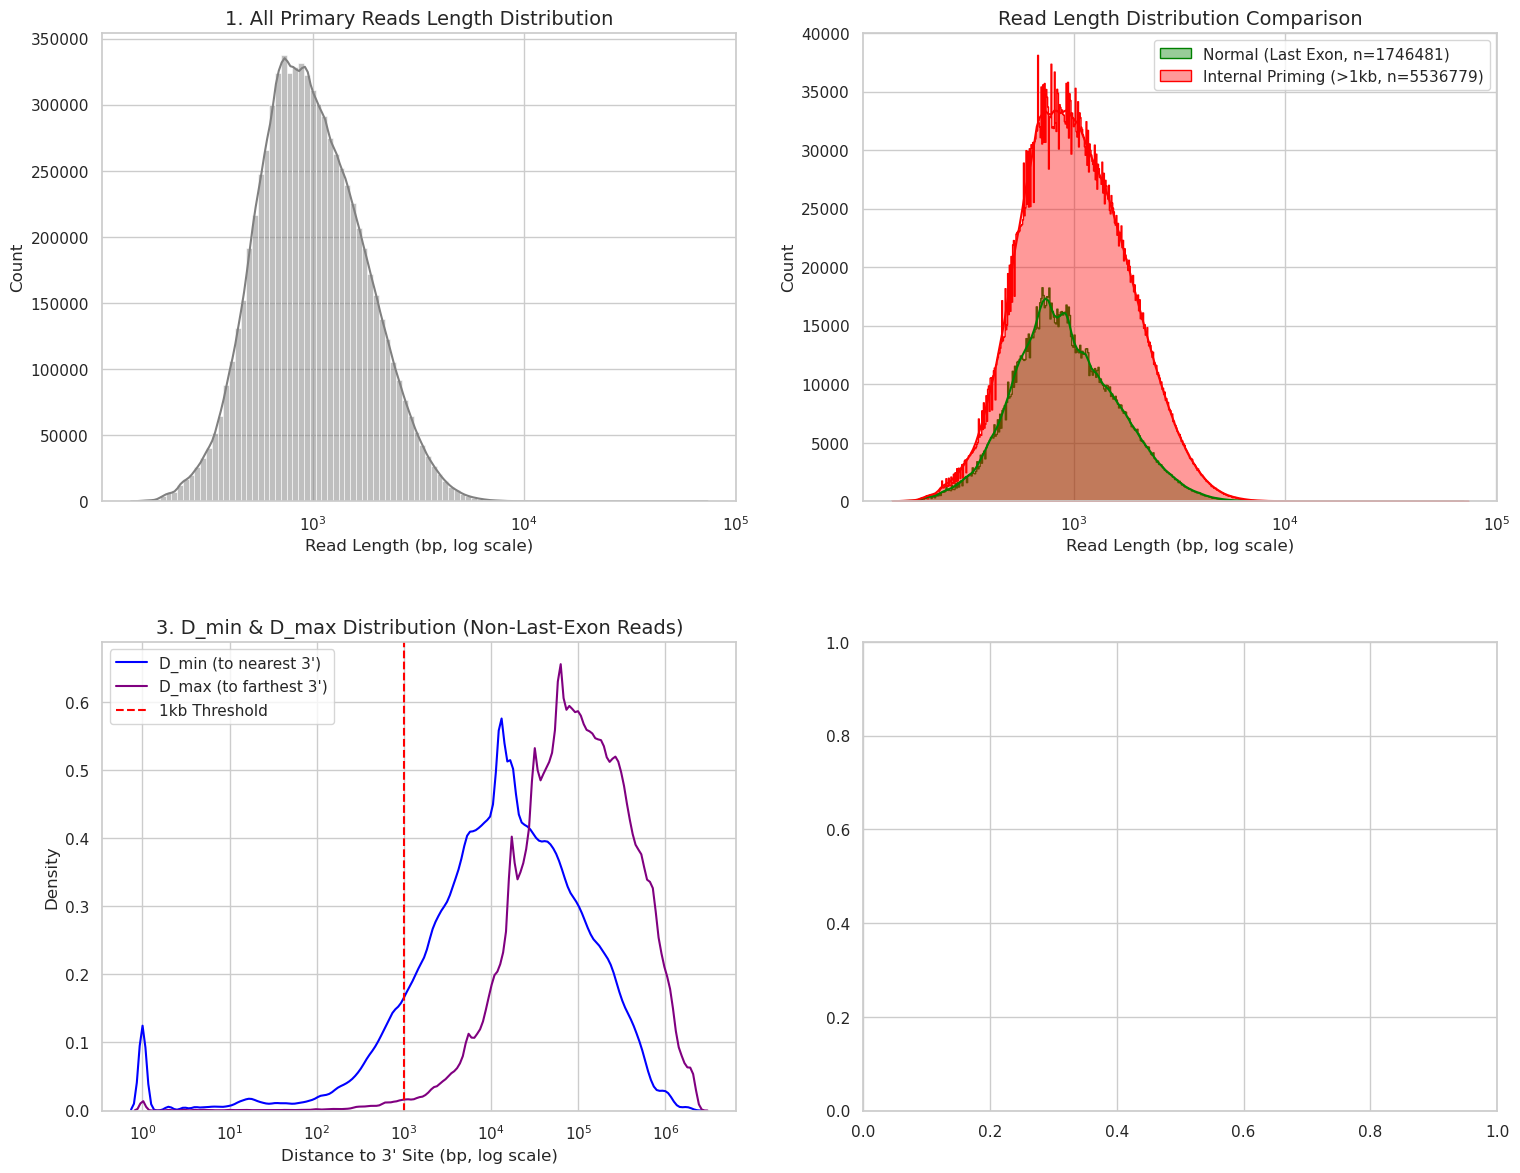

In [11]:
plot_comprehensive_capture_analysis(df_results)